In [32]:
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126
# %pip install torchinfo tqdm torchmetrics
# %pip install matplotlib
# %pip install torchao
# %reset

In [33]:
import torch
from torchvision import transforms
from torchvision.models import mobilenet_v3_large
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

device = 'cuda'
model = mobilenet_v3_large(num_classes=10).to(device)
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
from tqdm import tqdm
from torchmetrics import Accuracy
from torchao.quantization import Int8WeightOnlyConfig, quantize_

def train(model, device):
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    acc_metric = Accuracy("multiclass", num_classes=10).to(device)
    num_epochs = 100
    
    
    for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Epochs", disable=True):
        model.train()
        epoch_preds = []
        epoch_labels = []
        for batch in tqdm(train_loader, total=len(train_loader)):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            quantize_(model, Int8WeightOnlyConfig())
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_preds.append(outputs)
            epoch_labels.append(labels) 
        epoch_preds = torch.cat(epoch_preds)
        epoch_labels = torch.cat(epoch_labels)
        train_acc = acc_metric(epoch_preds, epoch_labels)
        if (epoch+1)%10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_acc:.4f}")

    print("Training complete.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train(model, device)

100%|██████████| 1563/1563 [02:39<00:00,  9.79it/s]


Epoch [10/100], Loss: 0.3003, Training Accuracy: 0.7813


100%|██████████| 1563/1563 [02:41<00:00,  9.69it/s]


Epoch [20/100], Loss: 0.6892, Training Accuracy: 0.8666


100%|██████████| 1563/1563 [02:40<00:00,  9.73it/s]


Epoch [30/100], Loss: 0.7598, Training Accuracy: 0.9147


100%|██████████| 1563/1563 [02:40<00:00,  9.75it/s]


Epoch [40/100], Loss: 0.0868, Training Accuracy: 0.9389


100%|██████████| 1563/1563 [02:34<00:00, 10.13it/s]


Epoch [50/100], Loss: 0.3227, Training Accuracy: 0.9511


100%|██████████| 1563/1563 [01:23<00:00, 18.69it/s]


Epoch [60/100], Loss: 0.5291, Training Accuracy: 0.9599


100%|██████████| 1563/1563 [01:23<00:00, 18.64it/s]


Epoch [70/100], Loss: 0.3759, Training Accuracy: 0.9683


100%|██████████| 1563/1563 [01:24<00:00, 18.48it/s]


Epoch [80/100], Loss: 0.0109, Training Accuracy: 0.9730


100%|██████████| 1563/1563 [01:23<00:00, 18.63it/s]


Epoch [90/100], Loss: 0.0083, Training Accuracy: 0.9756


100%|██████████| 1563/1563 [01:22<00:00, 18.89it/s]


Epoch [100/100], Loss: 0.2427, Training Accuracy: 0.9758
Training complete.


In [35]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0

for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_b = (param_size + buffer_size)
print('model size: {:.0f}B'.format(size_all_b))
from torch.utils.flop_counter import FlopCounterMode
from typing import Union, Tuple
def get_flops(model, inp: Union[torch.Tensor, Tuple], with_backward=False):
    istrain = model.training
    model.eval()
    
    inp = inp if isinstance(inp, torch.Tensor) else torch.randn(inp)
    inp = inp.to(device)
    flop_counter = FlopCounterMode(display=False, depth=None)
    with flop_counter:
        if with_backward:
            model(inp).sum().backward()
        else:
            model(inp)
    total_flops =  flop_counter.get_total_flops()
    if istrain:
        model.train()
    return total_flops
flops = get_flops(model, (1, 3, 28, 28))
print(f"Total FLOPs for a single forward pass: {flops:,}")

model size: 16957336B
Total FLOPs for a single forward pass: 13,713,040


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         3.76%      16.698ms         3.76%      16.698ms       5.865us       0.000us         0.00%       0.000us       0.000us       5.72 MB       5.72 MB     506.43 MB     506.43 M

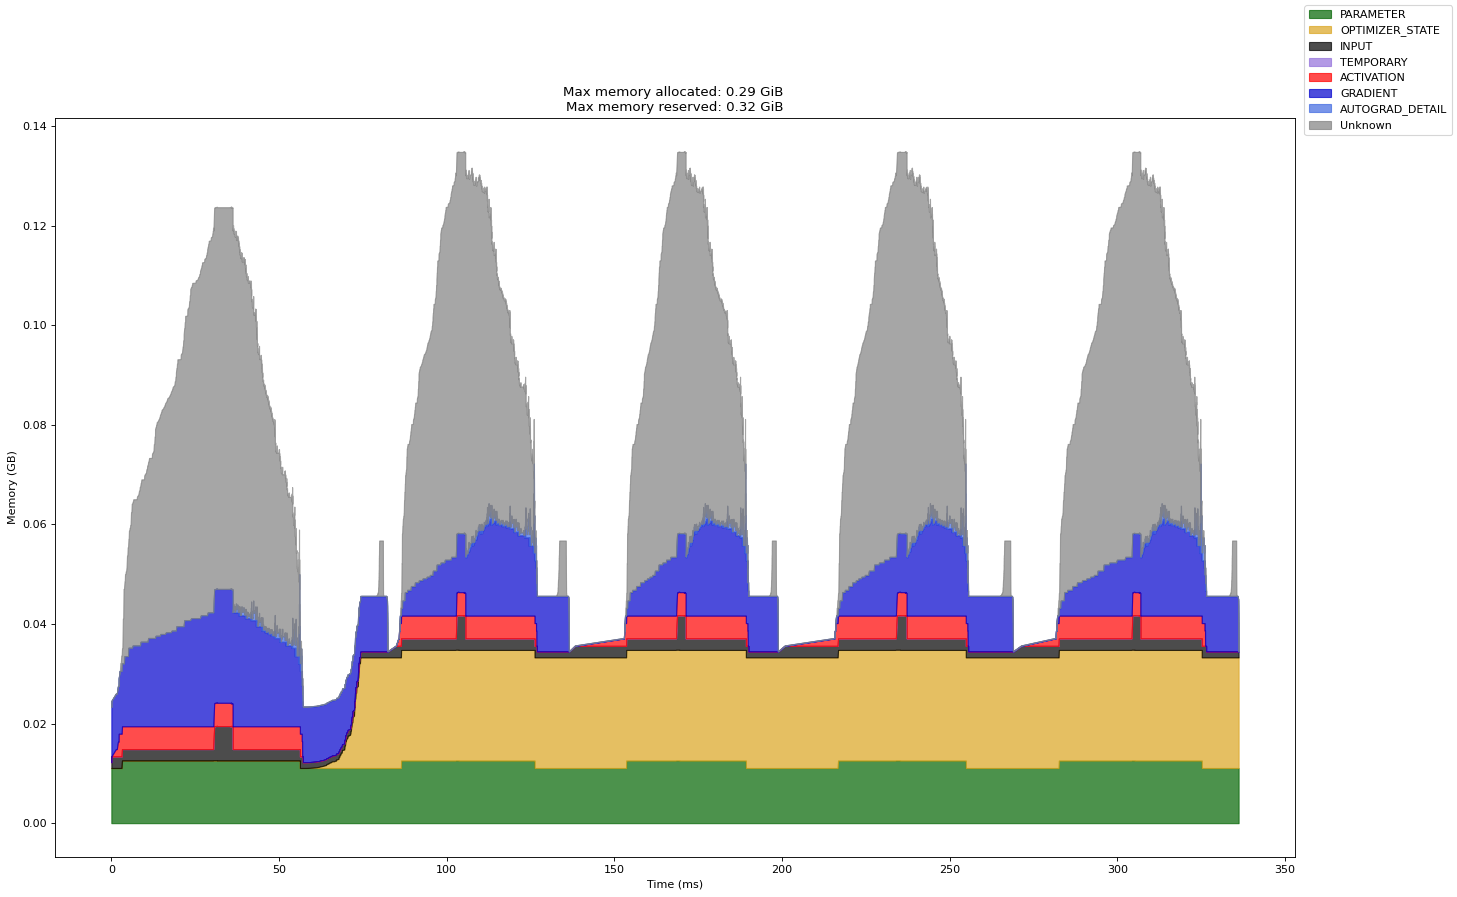

In [36]:
import torch.profiler
from torch.profiler import ProfilerActivity
from torch.autograd.profiler import record_function

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()
model.to(device)
with torch.profiler.profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
    profile_memory=True, 
    record_shapes=True, 
    with_stack=True
    ) as prof:
   
    for _ in range(5):
        prof.step()
        with record_function("## forward ##"):
            output = model(torch.randn((10, 3, 100, 100)).to(device))
        
        with record_function("## backward ##"):
            loss = output.sum()
            loss.backward()
        
        with record_function("## optimizer step ##"):
            optimizer.step()
            optimizer.zero_grad()

print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))
prof.export_memory_timeline(f"profiler_output_aware.html", device='cuda:0')


In [37]:
import os
torch.save(model, "./model_a.pt")
model_a_size_mb = os.path.getsize("./model_a.pt")/1024/1024
print(f'model size: {model_a_size_mb}')

model size: 12.779242515563965


In [38]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0

for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_b = (param_size + buffer_size)
print('model size: {:.0f}B'.format(size_all_b))
from torch.utils.flop_counter import FlopCounterMode
from typing import Union, Tuple
def get_flops(model, inp: Union[torch.Tensor, Tuple], with_backward=False):
    istrain = model.training
    model.eval()
    
    inp = inp if isinstance(inp, torch.Tensor) else torch.randn(inp)
    inp = inp.to("cuda" if torch.cuda.is_available() else "cpu")
    flop_counter = FlopCounterMode(display=False, depth=None)
    with flop_counter:
        if with_backward:
            model(inp).sum().backward()
        else:
            model(inp)
    total_flops =  flop_counter.get_total_flops()
    if istrain:
        model.train()
    return total_flops
flops = get_flops(model, (1, 3, 28, 28))
print(f"Total FLOPs for a single forward pass: {flops:,}")

model size: 16957336B
Total FLOPs for a single forward pass: 13,713,040
